First, I import all the required packages:

In [1]:
import numpy as np
import pandas as pd


from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import uniform

import matplotlib.pyplot as plt

We assumed the last entrant always gets only half the expected market share. So if we have n-1 entry, the nth firm's market share will be $\frac{B}{2n}$ and it will enter if its profit, $\pi=p(n)-C-\frac{2nF}{B}$, is bigger or equal to zero. The first price in each price scheme is 1, so this function set the price equal 1 for zero entry. Considering that, I write a function for selecting price from a price scheme for each sample:

In [2]:
def FPS(b,c,f,scheme):
    d=len(b) #Number of samples
    scheme = scheme[~np.isnan(scheme)] #Delete NaN value from the scheme
    Ls=len(scheme) #length of the price scheme
    
    Ns=np.zeros(d) #Number of entry for each sample
    Ps=np.ones(d) #Selected price for each sample

    for i in range(d):
        n=0 
        pn=scheme[0] 
        pn1=scheme[1] #price of the next entry
        pi=pn1-c[i]-((f[i])/b[i]) #profit of the first entry. 
        
        while (0<= pi):
            n=n+1 #Number of entries
            pn=pn1 #Price when we have n entries
            
            if (n+1) < Ls:
                pn1=scheme[n+1]
            else:
                pn1=scheme[Ls-1]
                
            pi=pn1-c[i]-((2*(n+1)*f[i])/b[i]) #profit of the next entry.
        
        Ns[i]=n
        Ps[i]=pn 

    return Ns,Ps

The next step is to set up all the parameters of the simulation:

In [3]:
B_shape, B_scale = 1.5, 10000000 #gamma function for B large country
b_shape, b_scale = 1.5, 2000000 #gamma function for B small country
C_alpha, C_beta = 1.3, 10 #beta function for C
C_alpha3, C_beta3 = 1.3, 3 #beta function for C
C_alpha5, C_beta5 = 1.3, 5 #beta function for C
F_min,F_max=30000, 500000 #min and max of the fixed cost

Here I plot Plot the probability distributions of the main variables: 

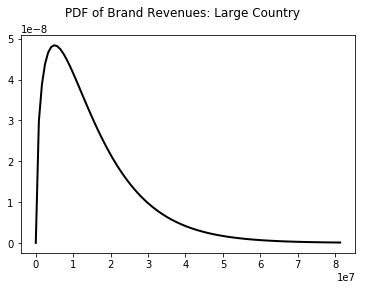

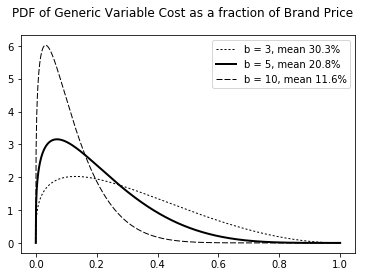

In [4]:
#Plot the probability distribution for B
fig, ax = plt.subplots(1, 1)
x = np.linspace(gamma.ppf(0, B_shape, scale=B_scale), gamma.ppf(0.999, B_shape, scale=B_scale), 100)
plt.suptitle('PDF of Brand Revenues: Large Country', fontsize=12)
ax.plot(x, gamma.pdf(x, B_shape, scale=B_scale),'k-',  lw=2, alpha=1, label='gamma pdf')
fig.savefig('Brand_Revenues.png', dpi=300)

#Plot the probability distribution for C
fig, ax = plt.subplots(1, 1)
x = np.linspace(beta.ppf(0, C_alpha, C_beta), beta.ppf(1, C_alpha, C_beta), 1000)
y = np.linspace(beta.ppf(0, C_alpha3, C_beta3), beta.ppf(1, C_alpha3, C_beta3), 1000)
z = np.linspace(beta.ppf(0, C_alpha5, C_beta5), beta.ppf(1, C_alpha5, C_beta5), 1000)
#z = np.linspace(beta.ppf(0, C_alpha, C_beta), beta.ppf(1, C_alpha, C_beta), 1000)
plt.suptitle('PDF of Generic Variable Cost as a fraction of Brand Price', fontsize=12)

ax.plot(y, beta.pdf(x, C_alpha3, C_beta3),'k-',  dashes=[2, 2],lw=1,  alpha=1, label='b = 3, mean 30.3%')
ax.plot(z, beta.pdf(x, C_alpha5, C_beta5),'k-',  lw=2, alpha=1, label='b = 5, mean 20.8%')
ax.plot(x, beta.pdf(x, C_alpha, C_beta),'k-', dashes=[6, 2], lw=1, alpha=1, label='b = 10, mean 11.6%')
plt.legend()
fig.savefig('Generic_Variable_Cost.png', dpi=300)

Random draw for each of the main variables:

In [5]:
D=10000 #Number of samples
seed=1 #seed for random generator

B = gamma.rvs(B_shape, scale=B_scale, size=D, random_state=seed) #Brand market size for large countries
b = gamma.rvs(b_shape, scale=b_scale, size=D, random_state=seed) #Brand market size for small countries
C = beta.rvs(C_alpha, C_beta, size=D, random_state=seed) #Generic variable cost

F = uniform.rvs(loc=F_min, scale=(F_max-F_min), size=D, random_state=seed) #Generic entry cost, per year

Calculating the average minimum prices for small and large countries:

In [6]:
MP=C+(F/B) #Minimum price for one entry for large countries. 

Mp=C+(F/b) #Minimum price for one entry for small countries. 


#Set prices equal to one if they are bigger than one. 

MP=np.clip(MP, 0, 1) 

Mp=np.clip(Mp, 0, 1) 

AMP=np.mean(MP) #Average minimum prices for large countries

AMp=np.mean(Mp) #Average minimum prices for small countries

The input file 'Tiers.xlsx' has all the price schemes for the simulation. Here I read the price schemes from the input file and save them in the variable "Schemes". I also crate the tables for saving the results. 

In [7]:
Schemes = pd.read_excel('Tiers.xlsx',header=0) #reading price scheme from the excel file

columns = pd.Index(['AMP','WAP', 'ACE', 'AGP','ANE','ShBP','PNS0','PNS1'])
index = pd.Index(Schemes.columns, name="Model")

Tab_L = pd.DataFrame(index=index, columns=columns) # define the result table for large countries
Tab_S = pd.DataFrame(index=index, columns=columns) # define the result table for small countries

Calculating the Results for large countries:

In [8]:
for Sch in Schemes.columns:
    NS,PS=FPS(B,C,F,Schemes[Sch]) #Sheme price and number of entry for each sample
    Tab_L.loc[Sch]['AMP']=AMP #Average minimum price
    Tab_L.loc[Sch]['WAP']=np.sum(B*PS)/np.sum(B) #Weighted average Price
    Tab_L.loc[Sch]['ACE']=np.sum(F*NS)/np.sum(B) #Average cost of entry
    Tab_L.loc[Sch]['AGP']=np.sum((B*(PS-C))-(F*NS))/np.sum(B) #Average profit
    Tab_L.loc[Sch]['ANE']=np.mean(NS) #Average number of entry 

    
    SP=np.sum((B*(PS-C))-(F*NS)) #Sum of profit
    
    #Variables for monopoly cases
    BM=B[NS==0]
    CM=C[NS==0]
    PSM=PS[NS==0]
    
    SBP=np.sum((BM*(PSM-CM))) #Sum of brand profit
    
    Tab_L.loc[Sch]['ShBP']=SBP/SP #Share of brand profit 
    
    LNS=len(NS) #The total number of markets
    
    Tab_L.loc[Sch]['PNS0']= (((NS==0).sum())/LNS) #Proportion of markets with 0 entrants
    
    Tab_L.loc[Sch]['PNS1']= (((NS==1).sum())/LNS) #Proportion of markets with 1 entrants
    
Tab_L.columns=['Average minimum price','Weighted average Price','Average cost of entry','Average profit','Average number of entry', 'Share of brand profit', 'Proportion of markets with 0 entrants', 'Proportion of markets with 1 entrant'] # Changing the name of columns

Tab_L.to_excel("Table(Large Countries).xlsx") #Saving the results into a exel file

Calculating the Results for small countries:

In [9]:
for Sch in Schemes.columns:
    NS,PS=FPS(b,C,F,Schemes[Sch]) #Sheme price and number of entry for each sample
    Tab_S.loc[Sch]['AMP']=AMp #Average minimum price
    Tab_S.loc[Sch]['WAP']=np.sum(b*PS)/np.sum(b) #Weighted average Price
    Tab_S.loc[Sch]['ACE']=np.sum(F*NS)/np.sum(b) #Average cost of entry
    Tab_S.loc[Sch]['AGP']=np.sum((b*(PS-C))-(F*NS))/np.sum(b) #Average generic profit
    Tab_S.loc[Sch]['ANE']=np.mean(NS) #Average number of entry 
    
    SP=np.sum((b*(PS-C))-(F*NS)) #Sum of profit
    
    #Variables for monopoly cases
    bM=b[NS==0]
    CM=C[NS==0]
    PSM=PS[NS==0]
    
    SBP=np.sum((bM*(PSM-CM))) #Sum of brand profit
    
    Tab_S.loc[Sch]['ShBP']=SBP/SP #Share of brand profit
    
    LNS=len(NS) #The total number of markets
    
    Tab_S.loc[Sch]['PNS0']= (((NS==0).sum())/LNS) #Proportion of markets with 0 entrants
    
    Tab_S.loc[Sch]['PNS1']= (((NS==1).sum())/LNS) #Proportion of markets with 1 entrants
    
Tab_S.columns=['Average minimum price','Weighted average Price','Average cost of entry','Average profit','Average number of entry', 'Share of brand profit', 'Proportion of markets with 0 entrants', 'Proportion of markets with 1 entrant'] # Changing the name of columns

Tab_S.to_excel("Table(Small Countries).xlsx") #Saving the results into a exel file